In [4]:
import random

import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from nsvd import NSVD

plt.set_cmap('gray')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using device:", device)

using device: cuda


<Figure size 640x480 with 0 Axes>

In [5]:
tf_train = transforms.Compose([
    transforms.RandomResizedCrop((168, 168), (0.7, 1)),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

tf_test = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

tf_normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
tf_denormalize = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1.0/0.247, 1.0/0.243, 1.0/0.261))

train = NSVD("./data", train=True, transform=tf_train)
test = NSVD("./data", train=False, transform=tf_train)

batch_size = 16
train_ldr = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4)
test_ldr = DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=4)
print("training data: {} images, {} batches".format(len(train), len(train_ldr)))
print("testing data: {} images, {} batches".format(len(test), len(test_ldr)))


training data: 12855 images, 804 batches
testing data: 1458 images, 92 batches


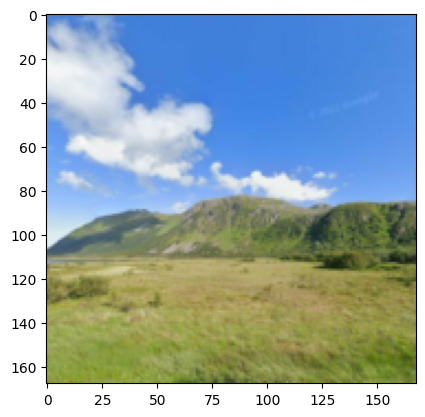

In [6]:
test_img = test[2][0]
plt.imshow(test_img.permute(1,2,0))

Regarding choice of loss function

https://arxiv.org/abs/2204.02980

In [5]:
torch.cuda.empty_cache()

from unet import UNet
model = UNet(1, 3)
model.to(device)


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00002)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)

epochs = 25
losses = {'train':[], 'test':[]}
for epoch in range(epochs):
    print("epoch: {}; lr: {:.8f}".format(epoch, scheduler.get_last_lr()[0]))
    model.train()
    train_loss = 0
    for batch_idx, (batch, _) in (pbar := tqdm(enumerate(train_ldr), total=len(train_ldr))):
        targets = batch.to(device)
        grayscale = F.rgb_to_grayscale(targets)
        y = model(grayscale)
        loss = loss_fn(y, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        pbar.set_description("    loss: {:.8f}".format(train_loss / (batch_idx + 1)))
    losses['train'].append(train_loss / len(train_ldr))

    model.eval()
    with torch.no_grad():
        test_loss = 0
        for batch_idx, (batch, _) in (pbar := tqdm(enumerate(test_ldr), total=len(test_ldr))):
            targets = batch.to(device)
            grayscale = F.rgb_to_grayscale(targets)
            y = model(grayscale)
            loss = loss_fn(y, targets)
            test_loss += loss.item()
            pbar.set_description("    loss: {:.8f}".format(test_loss / (batch_idx + 1)))
        losses['test'].append(test_loss / len(test_ldr))

    scheduler.step()


epoch: 0; lr: 0.00002000


    loss: 0.00777247: 100%|██████████| 92/92 [00:08<00:00, 10.64it/s]


epoch: 1; lr: 0.00001900


    loss: 0.00308829: 100%|██████████| 92/92 [00:08<00:00, 10.99it/s]


epoch: 2; lr: 0.00001805


    loss: 0.00257989: 100%|██████████| 92/92 [00:08<00:00, 10.98it/s]


epoch: 3; lr: 0.00001715


    loss: 0.00229257: 100%|██████████| 92/92 [00:08<00:00, 10.98it/s]


epoch: 4; lr: 0.00001629


    loss: 0.00218909: 100%|██████████| 92/92 [00:07<00:00, 11.64it/s]


epoch: 5; lr: 0.00001548


    loss: 0.00207312: 100%|██████████| 92/92 [00:08<00:00, 11.23it/s]


epoch: 6; lr: 0.00001470


    loss: 0.00218873: 100%|██████████| 92/92 [00:08<00:00, 11.26it/s]


epoch: 7; lr: 0.00001397


    loss: 0.00190668: 100%|██████████| 92/92 [00:08<00:00, 11.12it/s]


epoch: 8; lr: 0.00001327


    loss: 0.00192984: 100%|██████████| 92/92 [00:08<00:00, 11.32it/s]


epoch: 9; lr: 0.00001260


    loss: 0.00176945: 100%|██████████| 92/92 [00:09<00:00, 10.11it/s]


epoch: 10; lr: 0.00001197


    loss: 0.00173686: 100%|██████████| 92/92 [00:08<00:00, 11.06it/s]


epoch: 11; lr: 0.00001138


    loss: 0.00170825: 100%|██████████| 92/92 [00:08<00:00, 11.10it/s]


epoch: 12; lr: 0.00001081


    loss: 0.00170404: 100%|██████████| 92/92 [00:08<00:00, 11.02it/s]


epoch: 13; lr: 0.00001027


    loss: 0.00179155: 100%|██████████| 92/92 [00:08<00:00, 11.25it/s]


epoch: 14; lr: 0.00000975


    loss: 0.00162001: 100%|██████████| 92/92 [00:09<00:00,  9.97it/s]


epoch: 15; lr: 0.00000927


    loss: 0.00158730: 100%|██████████| 92/92 [00:08<00:00, 10.79it/s]


epoch: 16; lr: 0.00000880


    loss: 0.00154615: 100%|██████████| 92/92 [00:08<00:00, 10.47it/s]


epoch: 17; lr: 0.00000836


    loss: 0.00159956: 100%|██████████| 92/92 [00:09<00:00,  9.98it/s]


epoch: 18; lr: 0.00000794


    loss: 0.00147605: 100%|██████████| 92/92 [00:09<00:00, 10.05it/s]


epoch: 19; lr: 0.00000755


    loss: 0.00145446: 100%|██████████| 92/92 [00:08<00:00, 10.37it/s]


epoch: 20; lr: 0.00000717


    loss: 0.00146280: 100%|██████████| 92/92 [00:08<00:00, 10.54it/s]


epoch: 21; lr: 0.00000681


    loss: 0.00147699: 100%|██████████| 92/92 [00:09<00:00,  9.85it/s]


epoch: 22; lr: 0.00000647


    loss: 0.00143870: 100%|██████████| 92/92 [00:08<00:00, 10.74it/s]


epoch: 23; lr: 0.00000615


    loss: 0.00140001: 100%|██████████| 92/92 [00:08<00:00, 10.77it/s]


epoch: 24; lr: 0.00000584


    loss: 0.00138505: 100%|██████████| 92/92 [00:08<00:00, 10.57it/s]


In [9]:
torch.save(model, './models/colorize_25_2e-5_2.pt')

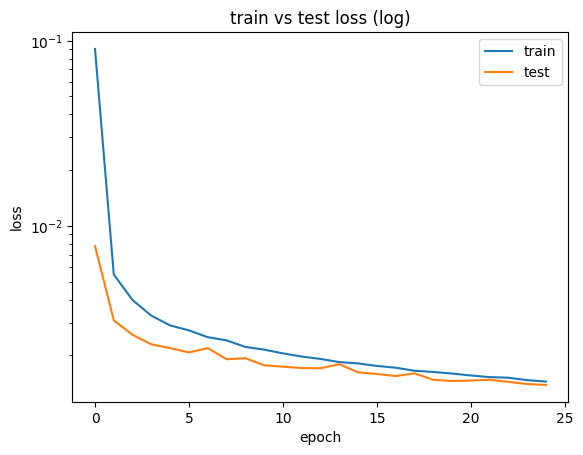

In [67]:
ax = plt.subplot()
ax.set_title('train vs test loss (log)')
ax.plot(np.arange(len(losses['train'])), losses['train'], label='train')
ax.plot(np.arange(len(losses['test'])), losses['test'], label='test')
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
plt.show()

In [7]:
model = torch.load('./models/colorize_25_2e-5.pt')

In [11]:
def compare(x: torch.Tensor):
    x = x.unsqueeze(0)

    x = x.to(device)
    x_gray = F.rgb_to_grayscale(x)
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))
    fig.set_facecolor('white')
    fig.tight_layout()

    axs[0].set_title('original')
    axs[0].imshow(x.squeeze().permute(1,2,0).cpu())
    axs[1].set_title('grayscaled')
    axs[1].imshow(x_gray.squeeze().cpu())

    with torch.no_grad():
        model.eval()
        out = model(x_gray)
        axs[2].set_title('prediction')
        axs[2].imshow(out.squeeze().permute(1,2,0).cpu())

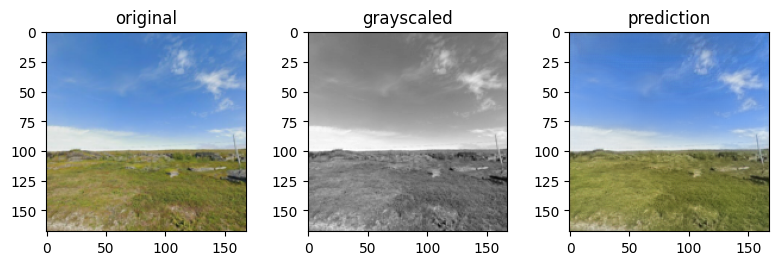

In [42]:
x = test[random.randint(0, len(test)-1)][0]
compare(x)

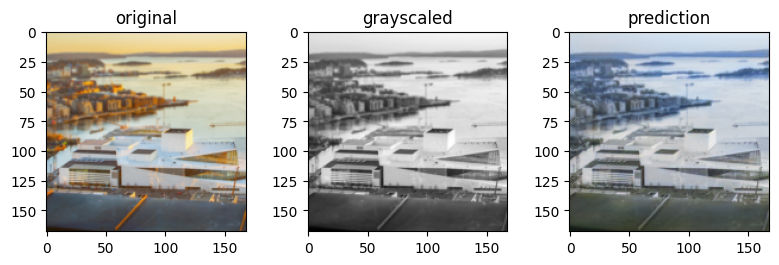

In [36]:
from PIL import Image
img = Image.open('./test_images/Opera_Oslo.jpg')
img = img.convert('RGB')
x = tf_train(img)
compare(x)